In [1]:
# Inference for ONNX model
import cv2
import time
import requests
import random
import numpy as np
import onnxruntime as ort
from PIL import Image
from pathlib import Path
from collections import OrderedDict,namedtuple

In [2]:
# 必要的图像处理函数-填充、缩放、尺寸调整
def letterbox(im, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleup=True, stride=32):
    # Resize and pad image while meeting stride-multiple constraints
    shape = im.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better val mAP)
        r = min(r, 1.0)

    # Compute padding
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding

    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, stride), np.mod(dh, stride)  # wh padding

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        im = cv2.resize(im, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return im, r, (dw, dh)

In [13]:
# 加载模型
w = "best.onnx"
# 模型搭载的设备
providers =['CPUExecutionProvider'] # cpu，可以换成GPU
# session是模型
session = ort.InferenceSession(w, providers=providers)
# 标签对应颜色
names = ['cipian', 'eluanshi', 'tudou', 'bailuobo', 'huluobo', 
         'yilaguan', 'bottle', 'battery', 'medician']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

In [14]:
# 加载图片并图片预处理
img = cv2.imread('image113.jpg')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

image = img.copy()
image, ratio, dwdh = letterbox(image, auto=False)
image = image.transpose((2, 0, 1))
image = np.expand_dims(image, 0)
image = np.ascontiguousarray(image)

im = image.astype(np.float32)
im /= 255
print(im.shape)

(1, 3, 640, 640)


In [15]:
outname = [i.name for i in session.get_outputs()]
outname

inname = [i.name for i in session.get_inputs()]
inname

inp = {inname[0]:im}

# ONNX inference
outputs = session.run(outname, inp)[0]
outputs

array([[  0.     ,  64.19795, 140.94888, 291.76038, 414.48636,   3.     ,
          0.93464]], dtype=float32)

3


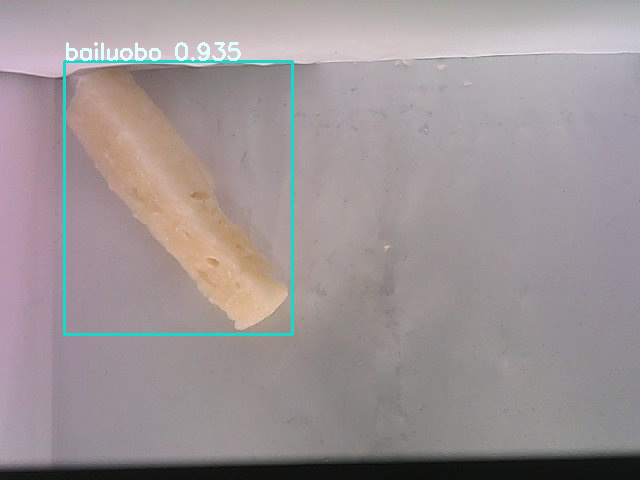

In [16]:
ori_images = [img.copy()]

for i,(batch_id,x0,y0,x1,y1,cls_id,score) in enumerate(outputs):
    image = ori_images[int(batch_id)]
    box = np.array([x0,y0,x1,y1]) # 框的位置坐标
    box -= np.array(dwdh*2)
    box /= ratio
    box = box.round().astype(np.int32).tolist()
    cls_id = int(cls_id) # 类别id
    print(cls_id)
    score = round(float(score),3)
    name = names[cls_id] # id对应的类别
    color = colors[name]
    name += ' '+str(score) # 类别+概率score
    # 画框
    cv2.rectangle(image,box[:2],box[2:],color,2)
    cv2.putText(image,name,(box[0], box[1] - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)  

Image.fromarray(ori_images[0]) # 显示图片